## Import Required Modules

In [207]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import random
from statsmodels.sandbox.regression.gmm import IV2SLS
from sklearn.linear_model import LinearRegression
from tqdm import tqdm 
from linearmodels.asset_pricing.model import LinearFactorModel

In [206]:
ols_model = LinearRegression()

In [2]:
random.seed(12345)

In [205]:
def froll_sum(x): 
    # Convert daily return to monthly return, use fix_rolling_sum function
    tmp = []
    for i in range(int(len(x)/21)): # 21 represents the trading days for one month
        res = np.sum(x[i*21:(i+1)*21])
        tmp.append(res)
    return tmp

In [718]:
def Shanken_lambda_nocons(df_betas, df_f, df_return, df_res):
    beta = pd.DataFrame(df_betas)
    res = df_res
    ret = df_return
    f = np.mat(df_f)
    N = len(beta)
    T = len(df_f)
    K = len((df_f).columns)
    
    X = np.mat(beta.reset_index(drop=True))#mat(N*K)
    X_mul = np.dot(X.T, X)/N #mat(K*K)
    
    cov_res = (1/(N*(T-K-1)))*np.diagonal(np.dot(res.T,res)).sum() #a value
    inv_f_mul = np.linalg.inv(np.dot(f.T,f)) #mat(K*K)
    
    mat = cov_res*inv_f_mul #mat(K*K)
    
    X_R = np.dot(X.T, ret.mean())/N #mat(K*1)
    
    adj_lam = np.dot(np.linalg.inv(X_mul - mat),X_R.T) #mat(K*1)
    return adj_lam

In [873]:
"""
Input Explanation:
df_beta is the dataframe of stock betas obtained by running the first stage of BJS regression  # mat(N*K)
df_f is the dataframe of factor realizations # mat(T*K)
df_return is the dataframe of excess stock returns # mat(T*K)
df_res is the dataframe of residuals obtained by running the first stage of BJS regression # mat(T*N)
"""

def Shanken_lambda(df_betas, df_f, df_return, df_res):
    beta = df_betas #only factor loadings no intercepts; mat(N*K)
    res = df_res
    ret = df_return
    f = np.mat(df_f)
    N = len(beta)
    T = len(df_f)
    K = len((df_f).columns)
    
    X = np.mat(pd.concat([pd.DataFrame({"Cons":np.repeat(1,N)}), beta.reset_index(drop=True)], axis=1))#mat(N*K+1)
    X_mul = np.dot(X.T, X)/N #mat(K+1*K+1)
    
    cov_res = (1/(N*(T-K-1)))*np.diagonal(np.dot(res.T,res)).sum() #a value
    inv_f_mul = np.linalg.inv(np.dot(f.T,f)) #mat(K*K)
    
    mat = cov_res*inv_f_mul #mat(K*K)
    tmp = np.insert(mat, 0, 0, axis=0) #mat(K+1*K)
    mat = np.insert(tmp, 0, 0, axis=1) #mat(K+1*K+1)
    
    X_R = np.dot(X.T, ret.mean())/N #mat(K+1*1)
    
    adj_lam = np.dot(np.linalg.inv(X_mul - mat),X_R.T) #mat(K+1*1)
    return adj_lam

## Comparing the Bias Under OLS and IV Approach

In [202]:
"""
Function CAPM_IV_Simulation is applied for automatically running simulation in
camparing the biases of Fama-MacBeth (1973) regression approach under IV and OLS estimation
method, respectively.

Parameters:
 
  
Inputs:
  T = number of years for simulation (years)
  N = number of portfolios/stocks for simulation
  t = rolling estimation window period (years)
  Repetitions = number of simulation times
  mean_beta = the mean of market betas of stocks 
  std_beta = the standard deviation of market betas of stocks
  mean_res_sig = the mean of the standard deviations of residuals
  std_res_sig = the standard deviation of the standard deviations of residuals
  mean_MKT = the mean of market returns
  std_MKT the standard deviation of market returns

Outputs:
  exante_bias_OLS: the ex-ante bias of OLS estimation and the corresponding mean under {Repetitions} simulations
  expost_bias_OLS: the ex-post bias of OLS estimation and the corresponding mean under {Repetitions} simulations
  exante_bias_IV: the ex-ante bias of IV estimation and the corresponding mean under {Repetitions} simulations
  expost_bias_IV: the ex-post bias of IV estimation and the corresponding mean under {Repetitions} simulations
  
  ##exante_RMSE_OLS: the ex-ante Root-mean-square deviation (RMSE) of OLS estimation
  ##expost_RMSE_OLS: the ex-post RMSE of OLS estimation
  ##exante_RMSE_IV: the ex-ante RMSE of IV estimation
  ##expost_RMSE_IV: the ex-post RMSE of IV estimation
"""

def froll_sum(x): 
    # Convert daily return to monthly return, use fix_rolling_sum function
    tmp = []
    for i in range(int(len(x)/21)): # 21 represents the trading days for one month
        res = np.sum(x[i*21:(i+1)*21])
        tmp.append(res)
    return tmp

def CAPM_IV_Simulation(mean_MKT, std_MKT, mean_beta, std_beta, mean_res_sig, std_res_sig, N, T, t, Repetitions):
    # how many days in the simulation data
    T = T*12*21
    #Step-1: For each stock, we randomly generate a beta and a standard deviations of return residuals from normal distributions.
    #simulate market betas for each stocks
    sim_betas_tmp = []
    sim_betas_tmp.append(np.random.normal(loc = mean_beta,scale = std_beta, size= N ))
    sim_betas = pd.DataFrame(sim_betas_tmp)

    #simulate the residual return standard deviations (sigmas)
    sim_sigmas_tmp = []
    sim_sigmas_tmp.append(np.random.normal(loc = mean_res_sig,scale = std_res_sig, size= N ))
    sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()

    exante_bias_BJS = []
    expost_bias_BJS = []
    
    exante_bias_OLS = []
    expost_bias_OLS = []

    exante_bias_IV = []
    expost_bias_IV = []

    for r in tqdm(range(Repetitions)):
        #Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation equal to the real mean and standard deviation from the sample data
        sim_MKT_tmp = []
        sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = std_MKT, size= T))
        sim_MKT = pd.DataFrame(sim_MKT_tmp).T

        #Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and standard deviation equal to the value generate in step-1
        res_return = pd.DataFrame()
        for j in range(N):
            returns = pd.DataFrame(np.random.normal(loc = 0,scale = sim_sig_res[j], size= T))
            res_return = pd.concat([res_return,returns], axis=1)
        res_return.columns = range(len(res_return.columns))
        #Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t
        sim_SR = pd.DataFrame((np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return)

        #Calculate the monthly return of simulating stock and market returns
        m_sim_SR = sim_SR.apply(lambda x: froll_sum(x))
        m_sim_MKT = sim_MKT.apply(lambda x: froll_sum(x))
        
                                            ####Section 2: if t != 0####
        if t==0:
            # Time-Series Regression (constant betas)
            betas = []
            for j in sim_SR.columns:
                OLS = sm.OLS(sim_SR.loc[:, j].values.astype(
                    np.float64), sim_MKT.values.astype(np.float64))
                res = OLS.fit()
                b = list(res.params)
                betas.append(b)
            df_betas = pd.DataFrame(betas).rename(columns={0:"MKT"})

            # 2nd Stage of FM_OLS Regression/ Risk Premium Estimation
            # Cross-sectional Regression (constant betas)
            lambdas = []
            sim_SR_T = sim_SR.T
            for k in sim_SR_T.columns:
                OLS = sm.OLS(sim_SR_T.loc[:,k].values, 
                    df_betas["MKT"].astype(np.float64))
                res = OLS.fit()
                l = list(res.params)
                lambdas.append(l)

    #             #or using package
    #             model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
    #             res_ols = model_ols.fit()
    #             lambdas = res_ols.risk_premia[0]

            exante_bias_bjs = ((np.mean(lambdas)-mean_MKT)/mean_MKT)*100
            expost_bias_bjs = ((np.mean(lambdas)-sim_MKT.values.mean())/sim_MKT.values.mean())*100

            exante_bias_BJS.append(exante_bias_bjs)
            expost_bias_BJS.append(expost_bias_bjs)
            
            print(f"The ex-ante bias of BJS: {exante_bias_BJS}",\
                 f"The mean of ex-ante bias of BJS among {Repetitions} simulations is: {sum(exante_bias_BJS)/len(exante_bias_BJS)}",\
                 f"The ex-post bias of BJS: {expost_bias_BJS}",\
                 f"The mean of ex-post bias of BJS among {Repetitions} simulations is: {sum(expost_bias_BJS)/len(expost_bias_BJS)}", sep='\n')

                                               ####Section 2: if t != 0####
        else:
            # Time-Series Regression (constant betas)
            betas = []
            for j in sim_SR.columns:
                OLS = sm.OLS(sim_SR.loc[:, j].values.astype(
                    np.float64), sim_MKT.values.astype(np.float64))
                res = OLS.fit()
                b = list(res.params)
                betas.append(b)
            df_betas = pd.DataFrame(betas).rename(columns={0:"MKT"})

            # 2nd Stage of FM_OLS Regression/ Risk Premium Estimation
            # Cross-sectional Regression (constant betas)
            lambdas = []
            sim_SR_T = sim_SR.T
            for k in sim_SR_T.columns:
                OLS = sm.OLS(sim_SR_T.loc[:,k].values, 
                    df_betas["MKT"].astype(np.float64))
                res = OLS.fit()
                l = list(res.params)
                lambdas.append(l)

    #             #or using linearmodel package
    #             model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
    #             res_ols = model_ols.fit()
    #             lambdas = res_ols.risk_premia[0]

            exante_bias_bjs = ((np.mean(lambdas)-mean_MKT)/mean_MKT)*100
            expost_bias_bjs = ((np.mean(lambdas)-sim_MKT.values.mean())/sim_MKT.values.mean())*100

            exante_bias_BJS.append(exante_bias_bjs)
            expost_bias_BJS.append(expost_bias_bjs)
            
            # FM_OLS Regression
            ## 1st Stage of FM_OLS Regression/ Beta Estimation
            holding = 21 # how many trading days for one month
            rollingW = t*12*holding
            periods = int((T - rollingW) / holding)
            # Time-Series Regression
            all_betas = []
            for i in range(periods):
                sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
                sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
                betas = []
                for j in sim_SR.columns:      
                    OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sim_MKT_tmp.values.astype(np.float64))
                    res = OLS.fit()
                    b = list(res.params)
                    betas.append(b)
                df_betas = pd.DataFrame(betas).rename(columns={0:'MKT'})
                all_betas.append(df_betas)

            # 2nd Stage of FM_OLS Regression/ Risk Premium Estimation
            holding = 1 # the following regression for risk premium estimation is performed monthly
            rollingW = t*12*holding
            lens = T/21
            periods = int((lens - rollingW)/holding)
            # Cross-sectional Regression
            all_lambdas_OLS = []
            all_resids_OLS = []
            lambdas = []
            resids = []
            m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T
            index_times = list(m_sim_SR_tmp_T.columns)
            for k in m_sim_SR_tmp_T.columns:   
                i = int(index_times.index(k)/holding)
                OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], all_betas[i].loc[:,"MKT"].astype(np.float64))
                res = OLS.fit()
                l = list(res.params)
                r = list(res.resid)
                lambdas.append(l)
                resids.append(r)        
            all_lambdas_OLS.append(pd.DataFrame(lambdas))
            all_resids_OLS.append(pd.DataFrame(resids))

            exante_bias_ols = ((np.mean(all_lambdas_OLS[0].iloc[:,0]) - mean_MKT*21)/(mean_MKT*21))*100
            expost_bias_ols = ((np.mean(all_lambdas_OLS[0].iloc[:,0]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values))*100

            exante_bias_OLS.append(exante_bias_ols)
            expost_bias_OLS.append(expost_bias_ols)

             # FM_IV Regression
            ## 1st Stage of FM_IV Regression/ Beta Estimation
            holding = 21
            rollingW = t *12 * holding
            periods = int((T - rollingW) / holding) 
            ## Time-Series Regression 
            all_betas_ev = []
            all_betas_iv = []

            for i in range(periods):
                sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
                sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]

                if (i + 1) % 2 == 1: # if i is odd month; e.g., Month 0(i.e., Jan) is odd month
                    rw_odd = pd.DataFrame() 
                    for k in range(0,t*12,2): # if current month is odd, extract all the past odd months in the rolling window to estimate explanatory betas
                        rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

                    betas_ev = []
                    for j in sim_SR.columns:
                        df_index = rw_odd.index
                        b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
                        betas_ev.append(b)
                    df_betas_ev = pd.DataFrame(np.array(betas_ev))
                    all_betas_ev.append(df_betas_ev)

                    rw_even = pd.DataFrame() 
                    for k in range(1,t*12,2):  # if current month is odd, extract all the past even months in the rolling window to estimate instrumental betas (lagged explanatory betas)      
                        rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

                    betas_iv = []
                    for j in sim_SR.columns:
                        df_index = rw_even.index   
                        b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
                        betas_iv.append(b)      
                    df_betas_iv = pd.DataFrame(np.array(betas_iv))
                    all_betas_iv.append(df_betas_iv)

                if (i + 1) % 2 == 0: # if i is even month; e.g., Month 1 (i.e., Feb) is even month
                    rw_odd = pd.DataFrame()
                    for k in range(1,t*12,2): # if current month is even, extract all the past odd months in the rolling window to estimate instrumental betas (lagged explanatory betas)
                        rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

                    betas_iv = []
                    for j in sim_SR.columns:
                        df_index = rw_odd.index   
                        b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
                        betas_iv.append(b)        
                    df_betas_iv = pd.DataFrame(np.array(betas_iv))
                    all_betas_iv.append(df_betas_iv)

                    rw_even = pd.DataFrame()  
                    for k in range(0,t*12,2): # if current month is even, extract all the past even months in the rolling window to estimate explanatory betas 
                        rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

                    betas_ev = []
                    for j in sim_SR.columns:
                        df_index = rw_even.index         
                        b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
                        betas_ev.append(b)
                    df_betas_ev = pd.DataFrame(np.array(betas_ev))
                    all_betas_ev.append(df_betas_ev)

            ## 2st Stage of FM_IV Regression/ Risk Premium Estimation
            holding = 1 
            rollingW = t * 12 * holding
            lens = T/21
            periods = int((lens - rollingW) / holding)
            ## Cross-Sectional Regression 
            all_lambdas_IV = []
            all_resids_IV = []
            lambdas = []
            resids = []
            m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T
            index_times = list(m_sim_SR_tmp_T.columns)

            for k in m_sim_SR_tmp_T.columns:
                i = int(index_times.index(k) / holding)
                iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = all_betas_ev[i].values.astype(np.float64),\
                        instrument = all_betas_iv[i].values.astype(np.float64))
                res = iv.fit()
                l = list(res.params)
                r = list(res.resid)
                lambdas.append(l)
                resids.append(r)

            all_lambdas_IV.append(pd.DataFrame(lambdas))
            all_resids_IV.append(pd.DataFrame(resids))

            exante_bias_iv = ((np.mean(all_lambdas_IV[0].iloc[:,0]) - mean_MKT*21)/(mean_MKT*21))*100
            expost_bias_iv = ((np.mean(all_lambdas_IV[0].iloc[:,0]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values))*100

            exante_bias_IV.append(exante_bias_iv)
            expost_bias_IV.append(expost_bias_iv)

            print(f"The ex-ante bias of BJS: {exante_bias_BJS}",\
                 f"The mean of ex-ante bias of BJS among {Repetitions} simulations is: {sum(exante_bias_BJS)/len(exante_bias_BJS)}",\
                 f"The ex-ante bias of OLS: {exante_bias_OLS}",\
                 f"The mean of ex-ante bias of OLS among {Repetitions} simulations is: {sum(exante_bias_OLS)/len(exante_bias_OLS)}",\
                 f"The ex-ante bias of IV: {exante_bias_IV}",\
                 f"The mean of ex-ante bias of IV among {Repetitions} simulations is: {sum(exante_bias_IV)/len(exante_bias_IV)}",\
                 f"The ex-post bias of BJS: {expost_bias_BJS}",\
                 f"The mean of ex-post bias of BJS among {Repetitions} simulations is: {sum(expost_bias_BJS)/len(expost_bias_BJS)}",\
                 f"The ex-post bias of OLS: {expost_bias_OLS}",\
                 f"The mean of ex-post bias of OLS among {Repetitions} simulations is: {sum(expost_bias_OLS)/len(expost_bias_OLS)}",\
                 f"The ex-post bias of IV: {expost_bias_IV}",\
                 f"The mean of ex-post bias of IV among {Repetitions} simulations is: {sum(expost_bias_IV)/len(expost_bias_IV)}", sep='\n')

## South African Example

In [204]:
# It takes about 3 min to finish one repetition/simulation, one can manually change the repetition times
CAPM_IV_Simulation(mean_MKT=0.00028, std_MKT=0.01155, mean_beta=0.14539, \
                    std_beta=0.20392, mean_res_sig=0.01614, std_res_sig=0.01390, \
                    N=100, T=5, t=1, Repetitions=2)

 50%|█████     | 1/2 [00:07<00:07,  7.11s/it]

The ex-ante bias of BJS: [117.14494793683528]
The mean of ex-ante bias of BJS among 2 simulations is: 117.14494793683528
The ex-ante bias of OLS: [-62.2373559037832]
The mean of ex-ante bias of OLS among 2 simulations is: -62.2373559037832
The ex-ante bias of IV: [-37.028164999880616]
The mean of ex-ante bias of IV among 2 simulations is: -37.028164999880616
The ex-post bias of BJS: [41.785328037504385]
The mean of ex-post bias of BJS among 2 simulations is: 41.785328037504385
The ex-post bias of OLS: [-75.34278862291056]
The mean of ex-post bias of OLS among 2 simulations is: -75.34278862291056
The ex-post bias of IV: [-58.88238539534105]
The mean of ex-post bias of IV among 2 simulations is: -58.88238539534105


100%|██████████| 2/2 [00:14<00:00,  7.21s/it]

The ex-ante bias of BJS: [117.14494793683528, -112.75709626594121]
The mean of ex-ante bias of BJS among 2 simulations is: 2.1939258354470326
The ex-ante bias of OLS: [-62.2373559037832, -173.67821615264265]
The mean of ex-ante bias of OLS among 2 simulations is: -117.95778602821292
The ex-ante bias of IV: [-37.028164999880616, -164.27967706136667]
The mean of ex-ante bias of IV among 2 simulations is: -100.65392103062365
The ex-post bias of BJS: [41.785328037504385, -114.96574356479248]
The mean of ex-post bias of BJS among 2 simulations is: -36.590207763644045
The ex-post bias of OLS: [-75.34278862291056, -186.43419052936403]
The mean of ex-post bias of OLS among 2 simulations is: -130.8884895761373
The ex-post bias of IV: [-58.88238539534105, -175.40847409738595]
The mean of ex-post bias of IV among 2 simulations is: -117.1454297463635


## Jegadeesh et al.(2019) Example

In [165]:
# It takes about 30 min to finish one repetition/simulation
CAPM_IV_Simulation(mean_MKT=0.00023, std_MKT=0.00966, mean_beta=0.95, \
                    std_beta=0.42, mean_res_sig=0.00233, std_res_sig=0.01499, \
                    N=2000, T=20, t=3, Repetitions=1)

100%|██████████| 1/1 [31:57<00:00, 1917.12s/it]

The ex-ante bias of CS: [-46.823052706748705]
The mean of ex-ante bias of CS among 1 simulations is: -46.823052706748705
The ex-ante bias of OLS: [-47.37524129415085]
The mean of ex-ante bias of OLS among 1 simulations is: -47.37524129415085
The ex-ante bias of IV: [-47.3763182513688]
The mean of ex-ante bias of IV among 1 simulations is: -47.3763182513688
The ex-post bias of CS: [4.46991404484493]
The mean of ex-post bias of CS among 1 simulations is: 4.46991404484493
The ex-post bias of OLS: [3.385100094462956]
The mean of ex-post bias of OLS among 1 simulations is: 3.385100094462956
The ex-post bias of IV: [3.382984335027407]
The mean of ex-post bias of IV among 1 simulations is: 3.382984335027407


## BJS with Shanken Adjustment

In [940]:
def CAPM_BJS_Simulation(mean_MKT, std_MKT, mean_beta, std_beta, mean_res_sig, std_res_sig, N, T, Repetitions):
    # how many days in the simulation data
    T = T*12*21
    #Step-1: For each stock, we randomly generate a beta and a standard deviations of return residuals from normal distributions.
    #simulate market betas for each stocks
    sim_betas_tmp = []
    sim_betas_tmp.append(np.random.normal(loc = mean_beta,scale = std_beta, size= N ))
    sim_betas = pd.DataFrame(sim_betas_tmp)

    #simulate the residual return standard deviations (sigmas)
    sim_sigmas_tmp = []
    sim_sigmas_tmp.append(np.random.normal(loc = mean_res_sig,scale = std_res_sig, size= N ))
    sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()

    exante_bias_BJS = []
    expost_bias_BJS = []
    

    for r in tqdm(range(Repetitions)):
        #Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation equal to the real mean and standard deviation from the sample data
        sim_MKT_tmp = []
        sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = std_MKT, size= T))
        sim_MKT = pd.DataFrame(sim_MKT_tmp).T

        #Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and standard deviation equal to the value generate in step-1
        res_return = pd.DataFrame()
        for j in range(N):
            returns = pd.DataFrame(np.random.normal(loc = 0,scale = sim_sig_res[j], size= T))
            res_return = pd.concat([res_return,returns], axis=1)
        res_return.columns = range(len(res_return.columns))
        #Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t
        sim_SR = pd.DataFrame((np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return)

        #Calculate the monthly return of simulating stock and market returns
        m_sim_SR = sim_SR.apply(lambda x: froll_sum(x))
        m_sim_MKT = sim_MKT.apply(lambda x: froll_sum(x))

        # Time-Series Regression (constant betas)
        betas = []
        resids = pd.DataFrame()
        for j in sim_SR.columns:
            OLS = sm.OLS(sim_SR.loc[:, j].values.astype(
                np.float64), sim_MKT.values.astype(np.float64))
            res = OLS.fit()
            r = pd.DataFrame(res.resid)
            b = list(res.params)
            resids = pd.concat([resids,r], axis=1)
            betas.append(b)
        df_betas = pd.DataFrame(betas).rename(columns={0:"MKT"})

        # 2nd Stage of FM_OLS Regression/ Risk Premium Estimation
        # Cross-sectional Regression (constant betas)
#         lambdas = []
#         sim_SR_T = sim_SR.T
#         for k in sim_SR_T.columns:
#             OLS = sm.OLS(sim_SR_T.loc[:,k].values, 
#                 df_betas["MKT"].astype(np.float64))
#             res = OLS.fit()
#             l = list(res.params)
#             lambdas.append(l)

#         #Using package
#         model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
#         res_ols = model_ols.fit()
#         lambdas = res_ols.risk_premia[0]

        #using Shanken correction
        lambdas = Shanken_lambda(df_betas, sim_MKT, sim_SR, resids)[1:] #regression with intercept
        
        #Calculate biases
        exante_bias_bjs = ((np.mean(lambdas)-mean_MKT)/mean_MKT)*100
        expost_bias_bjs = ((np.mean(lambdas)-sim_MKT.values.mean())/sim_MKT.values.mean())*100

        exante_bias_BJS.append(exante_bias_bjs)
        expost_bias_BJS.append(expost_bias_bjs)

    print(f"The ex-ante bias of BJS: {exante_bias_BJS}",\
         f"The mean of ex-ante bias of BJS among {Repetitions} simulations is: {sum(exante_bias_BJS)/len(exante_bias_BJS)}",\
         f"The ex-post bias of BJS: {expost_bias_BJS}",\
         f"The mean of ex-post bias of BJS among {Repetitions} simulations is: {sum(expost_bias_BJS)/len(expost_bias_BJS)}", sep='\n')


In [947]:
CAPM_BJS_Simulation(mean_MKT=0.00023, std_MKT=0.00966, mean_beta=0.95, \
                    std_beta=0.42, mean_res_sig=0.00233, std_res_sig=0.01499, \
                    N=1000, T=5, Repetitions=1)

100%|██████████| 1/1 [00:05<00:00,  5.87s/it]

The ex-ante bias of BJS: [111.48430733851767]
The mean of ex-ante bias of BJS among 1 simulations is: 111.48430733851767
The ex-post bias of BJS: [4.457600930488279]
The mean of ex-post bias of BJS among 1 simulations is: 4.457600930488279


In [1005]:
df_bias = pd.read_excel("BJS_bias.xlsx")
df_bias.loc[:,"z"] = np.abs(df_bias.loc[:,"z"].values)
df_bias_tmp = df_bias.sort_values(by = "z").reset_index(drop=True)

In [1020]:
df_bias_tmp

,x,y,z
0,3000,30,0.132840
1,2000,25,0.266300
2,2500,25,0.268005
3,3000,25,0.269710
4,2000,30,0.345600
5,2500,30,0.439220
6,2000,10,0.445500
7,2500,15,0.461600
8,2500,10,0.508800
9,3000,10,0.572100


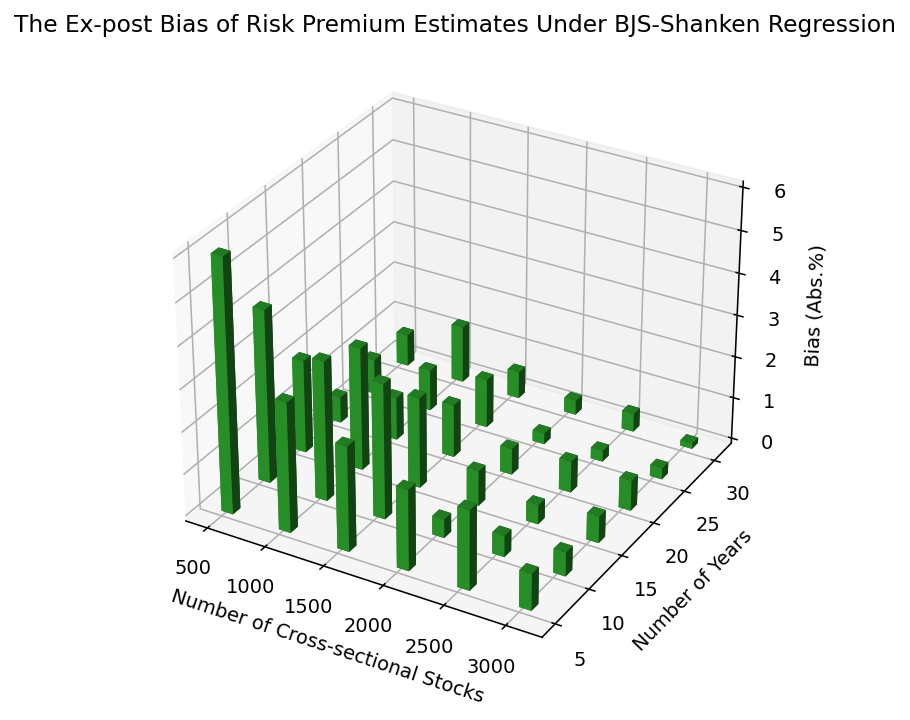

In [1023]:
from mpl_toolkits.mplot3d import Axes3D

x = df_bias.loc[:,"x"]
y = df_bias.loc[:,"y"]
z =  np.zeros(len(x))
dx = np.ones(len(x))*100
dy = np.ones(len(x))
dz = df_bias.loc[:,"z"]


fig = plt.figure(figsize=(10,6), dpi = 140)
ax = fig.add_subplot(projection='3d')
bar3d = ax.bar3d(x, y, z, dx, dy, dz, color='C2')

ax.set_title("The Ex-post Bias of Risk Premium Estimates Under BJS-Shanken Regression")
ax.set_xlabel('Number of Cross-sectional Stocks')
ax.set_ylabel('Number of Years')
ax.set_zlabel('Bias (Abs.%)')

plt.show()

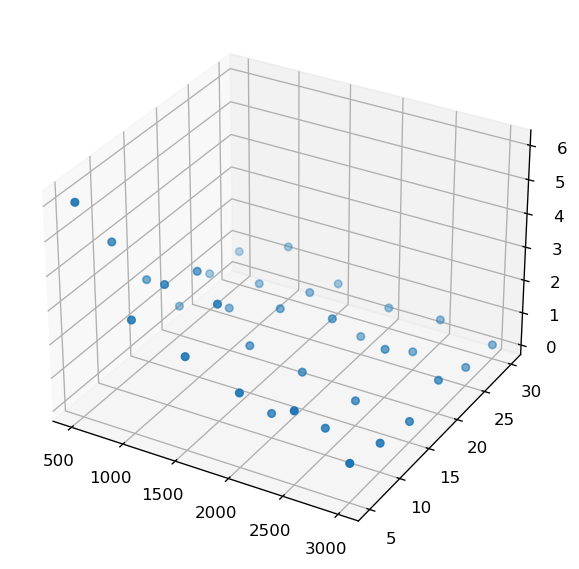

In [581]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

fig = plt.figure(figsize=(10,6), dpi = 120)
ax = fig.add_subplot(111, projection='3d')

x = df_bias.loc[:,"x"]
y = df_bias.loc[:,"y"]
z = df_bias.loc[:,"z"]

ax.scatter(x,y,z)

plt.show()

## Rolling FM with Shanken Adjustment

In [869]:
def CAPM_Sh_Simulation(mean_MKT, std_MKT, mean_beta, std_beta, mean_res_sig, std_res_sig, N, T, t, Repetitions):
    # how many days in the simulation data
    T = T*12*21
    #Step-1: For each stock, we randomly generate a beta and a standard deviations of return residuals from normal distributions.
    #simulate market betas for each stocks
    sim_betas_tmp = []
    sim_betas_tmp.append(np.random.normal(loc = mean_beta,scale = std_beta, size= N ))
    sim_betas = pd.DataFrame(sim_betas_tmp)

    #simulate the residual return standard deviations (sigmas)
    sim_sigmas_tmp = []
    sim_sigmas_tmp.append(np.random.normal(loc = mean_res_sig,scale = std_res_sig, size= N ))
    sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()

    exante_bias_Sh = []
    expost_bias_Sh = []
    

    for r in tqdm(range(Repetitions)):
        #Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation equal to the real mean and standard deviation from the sample data
        sim_MKT_tmp = []
        sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = std_MKT, size= T))
        sim_MKT = pd.DataFrame(sim_MKT_tmp).T

        #Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and standard deviation equal to the value generate in step-1
        res_return = pd.DataFrame()
        for j in range(N):
            returns = pd.DataFrame(np.random.normal(loc = 0,scale = sim_sig_res[j], size= T))
            res_return = pd.concat([res_return,returns], axis=1)
        res_return.columns = range(len(res_return.columns))
        #Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t
        sim_SR = pd.DataFrame((np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return)

        #Calculate the monthly return of simulating stock and market returns
        m_sim_SR = sim_SR.apply(lambda x: froll_sum(x))
        m_sim_MKT = sim_MKT.apply(lambda x: froll_sum(x))

        # FM_Shanken Regression
        holding = 21 # how many trading days for one month
        rollingW = t*12*holding
        periods = int((T - rollingW) / holding)
        # Time-Series Regression (constant betas)
        all_betas = []
        all_resids = []
        for i in range(periods):
            sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
            sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
            betas = []
            resids = pd.DataFrame()
            for j in sim_SR.columns:      
                OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sim_MKT_tmp.values.astype(np.float64))
                res = OLS.fit()
                b = list(res.params)
                r = pd.DataFrame(res.resid)
                resids = pd.concat([resids,r], axis=1)
                betas.append(b)
            df_betas = pd.DataFrame(betas).rename(columns={0:'MKT'})
            all_betas.append(df_betas)
            all_resids.append(resids)

        # 2nd Stage of FM_Shanken Regression/ Risk Premium Estimation
        all_lambdas_Sh = []
        lambdas = pd.DataFrame()
        for i in range(periods):
            sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
            sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]    
            l = pd.DataFrame(Shanken_lambda_nocons(all_betas[i].loc[:,"MKT"], sim_MKT_tmp, sim_SR_tmp, all_resids[i]))
            lambdas = pd.concat([lambdas,l],axis=0)
        all_lambdas_Sh.append(lambdas)

        exante_bias_sh = ((np.mean(all_lambdas_Sh[0].iloc[:,0]) - mean_MKT)/(mean_MKT))*100
        expost_bias_sh = ((np.mean(all_lambdas_Sh[0].iloc[:,0]) - np.mean(sim_MKT.values))/np.mean(sim_MKT.values))*100

        exante_bias_Sh.append(exante_bias_sh)
        expost_bias_Sh.append(expost_bias_sh)
        
    print(f"The ex-ante bias of Shanken: {exante_bias_Sh}",\
         f"The mean of ex-ante bias of Shanken among {Repetitions} simulations is: {sum(exante_bias_Sh)/len(exante_bias_Sh)}",\
         f"The ex-post bias of Shanken: {expost_bias_Sh}",\
         f"The mean of ex-post bias of Shanken among {Repetitions} simulations is: {sum(expost_bias_Sh)/len(expost_bias_Sh)}", sep='\n')


In [870]:
# It takes about 3 min to finish one repetition/simulation, one can manually change the repetition times
CAPM_Sh_Simulation(mean_MKT=0.00028, std_MKT=0.01155, mean_beta=0.14539, \
                    std_beta=0.20392, mean_res_sig=0.01614, std_res_sig=0.01390, \
                    N=500, T=10, t=1, Repetitions=2)

100%|██████████| 2/2 [08:31<00:00, 255.76s/it]

The ex-ante bias of Shanken: [58.9836811205784, 31.653903340898864]
The mean of ex-ante bias of Shanken among 2 simulations is: 45.31879223073864
The ex-post bias of Shanken: [86.18296849332992, 5.980238173218537]
The mean of ex-post bias of Shanken among 2 simulations is: 46.08160333327423


In [994]:
mean_MKT=0.00028
std_MKT=0.01155
mean_beta=0.14539
std_beta=0.20392
mean_res_sig=0.01614
std_res_sig=0.01390
N=500
T=10
t=1
Repetitions=1
# how many days in the simulation data
T = T*12*21
#Step-1: For each stock, we randomly generate a beta and a standard deviations of return residuals from normal distributions.
#simulate market betas for each stocks
sim_betas_tmp = []
sim_betas_tmp.append(np.random.normal(loc = mean_beta,scale = std_beta, size= N ))
sim_betas = pd.DataFrame(sim_betas_tmp)

#simulate the residual return standard deviations (sigmas)
sim_sigmas_tmp = []
sim_sigmas_tmp.append(np.random.normal(loc = mean_res_sig,scale = std_res_sig, size= N ))
sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()

exante_bias_Sh = []
expost_bias_Sh = []


for r in tqdm(range(Repetitions)):
    #Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation equal to the real mean and standard deviation from the sample data
    sim_MKT_tmp = []
    sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = std_MKT, size= T))
    sim_MKT = pd.DataFrame(sim_MKT_tmp).T

    #Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and standard deviation equal to the value generate in step-1
    res_return = pd.DataFrame()
    for j in range(N):
        returns = pd.DataFrame(np.random.normal(loc = 0,scale = sim_sig_res[j], size= T))
        res_return = pd.concat([res_return,returns], axis=1)
    res_return.columns = range(len(res_return.columns))
    #Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t
    sim_SR = pd.DataFrame((np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return)

    #Calculate the monthly return of simulating stock and market returns
    m_sim_SR = sim_SR.apply(lambda x: froll_sum(x))
    m_sim_MKT = sim_MKT.apply(lambda x: froll_sum(x))
    # FM-Shanken Regression
    holding = 21 # how many trading days for one month
    rollingW = t*12*holding
    periods = int((T - rollingW) / holding)
    # Time-Series Regression (constant betas)
    all_betas = []
    all_resids = []
    for i in range(periods):
        sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
        sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
        betas = []
        resids = pd.DataFrame()
        for j in sim_SR.columns:      
            OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sim_MKT_tmp.values.astype(np.float64))
            res = OLS.fit()
            b = list(res.params)
            r = pd.DataFrame(res.resid)
            resids = pd.concat([resids,r], axis=1)
            betas.append(b)
        df_betas = pd.DataFrame(betas).rename(columns={0:'MKT'})
        all_betas.append(df_betas)
        all_resids.append(resids)

    # 2nd Stage of FM_Shanken Regression/ Risk Premium Estimation
    all_lambdas_Sh = []
    lambdas = pd.DataFrame()
    for i in range(periods):
        sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
        sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]    
        l = pd.DataFrame(Shanken_lambda(all_betas[i].loc[:,"MKT"], sim_MKT_tmp, sim_SR_tmp, all_resids[i])[1:])
        lambdas = pd.concat([lambdas,l],axis=0)
    all_lambdas_Sh.append(lambdas.reset_index(drop=True))
    
# BJS-Shanken Time-Series Regression (constant betas) 
    betas = []
    resids = pd.DataFrame()
    for j in sim_SR.columns:
        OLS = sm.OLS(sim_SR.loc[:, j].values.astype(
            np.float64), sim_MKT.values.astype(np.float64))
        res = OLS.fit()
        r = pd.DataFrame(res.resid)
        b = list(res.params)
        resids = pd.concat([resids,r], axis=1)
        betas.append(b)
    df_betas = pd.DataFrame(betas).rename(columns={0:"MKT"})

    # 2nd Stage of FM_OLS Regression/ Risk Premium Estimation
    # Cross-sectional Regression (constant betas)
#         lambdas = []
#         sim_SR_T = sim_SR.T
#         for k in sim_SR_T.columns:
#             OLS = sm.OLS(sim_SR_T.loc[:,k].values, 
#                 df_betas["MKT"].astype(np.float64))
#             res = OLS.fit()
#             l = list(res.params)
#             lambdas.append(l)

#         #Using package
#         model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
#         res_ols = model_ols.fit()
#         lambdas = res_ols.risk_premia[0]

    #using BJS Shanken correction
    lambdas_BJS = Shanken_lambda(df_betas, sim_MKT, sim_SR, resids)[1:] # exclude the intercept (alpha)


100%|██████████| 1/1 [00:53<00:00, 53.02s/it]


In [995]:
#FM-Shanken (Rolling-window)
((np.mean(all_lambdas_Sh[0].iloc[:,0]) - np.mean(sim_MKT.values))/np.mean(sim_MKT.values))*100

-132.25262658221607

In [996]:
#BJS-Shanken
((lambdas_BJS - np.mean(sim_MKT.values))/np.mean(sim_MKT.values))*100

matrix([[18.00644603]])

In [997]:
"""
Function CAPM_IV_Simulation is applied for automatically running simulation in
camparing the biases of Fama-MacBeth (1973) regression approach under IV and OLS estimation
method, respectively.

Parameters:
 
  
Inputs:
  T = number of years for simulation (years)
  N = number of portfolios/stocks for simulation
  t = rolling estimation window period (years)
  Repetitions = number of simulation times
  mean_beta = the mean of market betas of stocks 
  std_beta = the standard deviation of market betas of stocks
  mean_res_sig = the mean of the standard deviations of residuals
  std_res_sig = the standard deviation of the standard deviations of residuals
  mean_MKT = the mean of market returns
  std_MKT the standard deviation of market returns

Outputs:
  exante_bias_OLS: the ex-ante bias of OLS estimation and the corresponding mean under {Repetitions} simulations
  expost_bias_OLS: the ex-post bias of OLS estimation and the corresponding mean under {Repetitions} simulations
  exante_bias_IV: the ex-ante bias of IV estimation and the corresponding mean under {Repetitions} simulations
  expost_bias_IV: the ex-post bias of IV estimation and the corresponding mean under {Repetitions} simulations
  
  ##exante_RMSE_OLS: the ex-ante Root-mean-square deviation (RMSE) of OLS estimation
  ##expost_RMSE_OLS: the ex-post RMSE of OLS estimation
  ##exante_RMSE_IV: the ex-ante RMSE of IV estimation
  ##expost_RMSE_IV: the ex-post RMSE of IV estimation
"""

def froll_sum(x): 
    # Convert daily return to monthly return, use fix_rolling_sum function
    tmp = []
    for i in range(int(len(x)/21)): # 21 represents the trading days for one month
        res = np.sum(x[i*21:(i+1)*21])
        tmp.append(res)
    return tmp

def CAPM_IV_Simulation(mean_MKT, std_MKT, mean_beta, std_beta, mean_res_sig, std_res_sig, N, T, t, Repetitions):
    # how many days in the simulation data
    T = T*12*21
    #Step-1: For each stock, we randomly generate a beta and a standard deviations of return residuals from normal distributions.
    #simulate market betas for each stocks
    sim_betas_tmp = []
    sim_betas_tmp.append(np.random.normal(loc = mean_beta,scale = std_beta, size= N ))
    sim_betas = pd.DataFrame(sim_betas_tmp)

    #simulate the residual return standard deviations (sigmas)
    sim_sigmas_tmp = []
    sim_sigmas_tmp.append(np.random.normal(loc = mean_res_sig,scale = std_res_sig, size= N ))
    sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()

    exante_bias_Sh = []
    expost_bias_Sh = []
    
    exante_bias_OLS = []
    expost_bias_OLS = []

    exante_bias_IV = []
    expost_bias_IV = []

    for r in tqdm(range(Repetitions)):
        #Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation equal to the real mean and standard deviation from the sample data
        sim_MKT_tmp = []
        sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = std_MKT, size= T))
        sim_MKT = pd.DataFrame(sim_MKT_tmp).T

        #Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and standard deviation equal to the value generate in step-1
        res_return = pd.DataFrame()
        for j in range(N):
            returns = pd.DataFrame(np.random.normal(loc = 0,scale = sim_sig_res[j], size= T))
            res_return = pd.concat([res_return,returns], axis=1)
        res_return.columns = range(len(res_return.columns))
        #Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t
        sim_SR = pd.DataFrame((np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return)

        #Calculate the monthly return of simulating stock and market returns
        m_sim_SR = sim_SR.apply(lambda x: froll_sum(x))
        m_sim_MKT = sim_MKT.apply(lambda x: froll_sum(x))
        
                                            ####Section 2: if t == 0####
        if t==0:
            # Time-Series Regression (constant betas)
            betas = []
            for j in sim_SR.columns:
                OLS = sm.OLS(sim_SR.loc[:, j].values.astype(
                    np.float64), sim_MKT.values.astype(np.float64))
                res = OLS.fit()
                b = list(res.params)
                betas.append(b)
            df_betas = pd.DataFrame(betas).rename(columns={0:"MKT"})

            # 2nd Stage of FM_OLS Regression/ Risk Premium Estimation
            # Cross-sectional Regression (constant betas)
            lambdas = []
            sim_SR_T = sim_SR.T
            for k in sim_SR_T.columns:
                OLS = sm.OLS(sim_SR_T.loc[:,k].values, 
                    df_betas["MKT"].astype(np.float64))
                res = OLS.fit()
                l = list(res.params)
                lambdas.append(l)

    #             #or using package
    #             model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
    #             res_ols = model_ols.fit()
    #             lambdas = res_ols.risk_premia[0]

            exante_bias_bjs = ((np.mean(lambdas)-mean_MKT)/mean_MKT)*100
            expost_bias_bjs = ((np.mean(lambdas)-sim_MKT.values.mean())/sim_MKT.values.mean())*100

            exante_bias_BJS.append(exante_bias_bjs)
            expost_bias_BJS.append(expost_bias_bjs)
            
            print(f"The ex-ante bias of BJS: {exante_bias_BJS}",\
                 f"The mean of ex-ante bias of BJS among {Repetitions} simulations is: {sum(exante_bias_BJS)/len(exante_bias_BJS)}",\
                 f"The ex-post bias of BJS: {expost_bias_BJS}",\
                 f"The mean of ex-post bias of BJS among {Repetitions} simulations is: {sum(expost_bias_BJS)/len(expost_bias_BJS)}", sep='\n')

                                               ####Section 2: if t != 0####
        else:
            # FM_Shanken Regression
            holding = 21 # how many trading days for one month
            rollingW = t*12*holding
            periods = int((T - rollingW) / holding)
            # Time-Series Regression (constant betas)
            all_betas = []
            all_resids = []
            for i in range(periods):
                sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
                sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
                betas = []
                resids = pd.DataFrame()
                for j in sim_SR.columns:      
                    OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sim_MKT_tmp.values.astype(np.float64))
                    res = OLS.fit()
                    b = list(res.params)
                    r = pd.DataFrame(res.resid)
                    resids = pd.concat([resids,r], axis=1)
                    betas.append(b)
                df_betas = pd.DataFrame(betas).rename(columns={0:'MKT'})
                all_betas.append(df_betas)
                all_resids.append(resids)
                
            # 2nd Stage of FM_Shanken Regression/ Risk Premium Estimation
            all_lambdas_Sh = []
            lambdas = pd.DataFrame()
            for i in range(periods):
                sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
                sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]    
                l = pd.DataFrame(Shanken_lambda(all_betas[i].loc[:,"MKT"], sim_MKT_tmp, sim_SR_tmp, all_resids[i])[1:])
                lambdas = pd.concat([lambdas,l],axis=0)
            all_lambdas_Sh.append(lambdas)

            exante_bias_sh = ((np.mean(all_lambdas_Sh[0].iloc[:,0]) - mean_MKT)/(mean_MKT))*100
            expost_bias_sh = ((np.mean(all_lambdas_Sh[0].iloc[:,0]) - np.mean(sim_MKT.values))/np.mean(sim_MKT.values))*100

            exante_bias_Sh.append(exante_bias_sh)
            expost_bias_Sh.append(expost_bias_sh)
          
            # FM_OLS Regression
            ## 1st Stage of FM_OLS Regression/ Beta Estimation
            holding = 21 # how many trading days for one month
            rollingW = t*12*holding
            periods = int((T - rollingW) / holding)
            # Time-Series Regression
            all_betas = []
            for i in range(periods):
                sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
                sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
                betas = []
                for j in sim_SR.columns:      
                    OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sim_MKT_tmp.values.astype(np.float64))
                    res = OLS.fit()
                    b = list(res.params)
                    betas.append(b)
                df_betas = pd.DataFrame(betas).rename(columns={0:'MKT'})
                all_betas.append(df_betas)

            # 2nd Stage of FM_OLS Regression/ Risk Premium Estimation
            holding = 1 # the following regression for risk premium estimation is performed monthly
            rollingW = t*12*holding
            lens = T/21
            periods = int((lens - rollingW)/holding)
            # Cross-sectional Regression
            all_lambdas_OLS = []
            all_resids_OLS = []
            lambdas = []
            resids = []
            m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T
            index_times = list(m_sim_SR_tmp_T.columns)
            for k in m_sim_SR_tmp_T.columns:   
                i = int(index_times.index(k)/holding)
                OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], all_betas[i].loc[:,"MKT"].astype(np.float64))
                res = OLS.fit()
                l = list(res.params)
                r = list(res.resid)
                lambdas.append(l)
                resids.append(r)        
            all_lambdas_OLS.append(pd.DataFrame(lambdas))
            all_resids_OLS.append(pd.DataFrame(resids))

            exante_bias_ols = ((np.mean(all_lambdas_OLS[0].iloc[:,0]) - mean_MKT*21)/(mean_MKT*21))*100
            expost_bias_ols = ((np.mean(all_lambdas_OLS[0].iloc[:,0]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values))*100

            exante_bias_OLS.append(exante_bias_ols)
            expost_bias_OLS.append(expost_bias_ols)

             # FM_IV Regression
            ## 1st Stage of FM_IV Regression/ Beta Estimation
            holding = 21
            rollingW = t *12 * holding
            periods = int((T - rollingW) / holding) 
            ## Time-Series Regression 
            all_betas_ev = []
            all_betas_iv = []

            for i in range(periods):
                sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
                sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]

                if (i + 1) % 2 == 1: # if i is odd month; e.g., Month 0(i.e., Jan) is odd month
                    rw_odd = pd.DataFrame() 
                    for k in range(0,t*12,2): # if current month is odd, extract all the past odd months in the rolling window to estimate explanatory betas
                        rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

                    betas_ev = []
                    for j in sim_SR.columns:
                        df_index = rw_odd.index
                        b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
                        betas_ev.append(b)
                    df_betas_ev = pd.DataFrame(np.array(betas_ev))
                    all_betas_ev.append(df_betas_ev)

                    rw_even = pd.DataFrame() 
                    for k in range(1,t*12,2):  # if current month is odd, extract all the past even months in the rolling window to estimate instrumental betas (lagged explanatory betas)      
                        rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

                    betas_iv = []
                    for j in sim_SR.columns:
                        df_index = rw_even.index   
                        b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
                        betas_iv.append(b)      
                    df_betas_iv = pd.DataFrame(np.array(betas_iv))
                    all_betas_iv.append(df_betas_iv)

                if (i + 1) % 2 == 0: # if i is even month; e.g., Month 1 (i.e., Feb) is even month
                    rw_odd = pd.DataFrame()
                    for k in range(1,t*12,2): # if current month is even, extract all the past odd months in the rolling window to estimate instrumental betas (lagged explanatory betas)
                        rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

                    betas_iv = []
                    for j in sim_SR.columns:
                        df_index = rw_odd.index   
                        b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
                        betas_iv.append(b)        
                    df_betas_iv = pd.DataFrame(np.array(betas_iv))
                    all_betas_iv.append(df_betas_iv)

                    rw_even = pd.DataFrame()  
                    for k in range(0,t*12,2): # if current month is even, extract all the past even months in the rolling window to estimate explanatory betas 
                        rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

                    betas_ev = []
                    for j in sim_SR.columns:
                        df_index = rw_even.index         
                        b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
                        betas_ev.append(b)
                    df_betas_ev = pd.DataFrame(np.array(betas_ev))
                    all_betas_ev.append(df_betas_ev)

            ## 2st Stage of FM_IV Regression/ Risk Premium Estimation
            holding = 1 
            rollingW = t * 12 * holding
            lens = T/21
            periods = int((lens - rollingW) / holding)
            ## Cross-Sectional Regression 
            all_lambdas_IV = []
            all_resids_IV = []
            lambdas = []
            resids = []
            m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T
            index_times = list(m_sim_SR_tmp_T.columns)

            for k in m_sim_SR_tmp_T.columns:
                i = int(index_times.index(k) / holding)
                iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = all_betas_ev[i].values.astype(np.float64),\
                        instrument = all_betas_iv[i].values.astype(np.float64))
                res = iv.fit()
                l = list(res.params)
                r = list(res.resid)
                lambdas.append(l)
                resids.append(r)

            all_lambdas_IV.append(pd.DataFrame(lambdas))
            all_resids_IV.append(pd.DataFrame(resids))

            exante_bias_iv = ((np.mean(all_lambdas_IV[0].iloc[:,0]) - mean_MKT*21)/(mean_MKT*21))*100
            expost_bias_iv = ((np.mean(all_lambdas_IV[0].iloc[:,0]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values))*100

            exante_bias_IV.append(exante_bias_iv)
            expost_bias_IV.append(expost_bias_iv)

            print(f"The ex-ante bias of Shanken: {exante_bias_Sh}",\
                 f"The mean of ex-ante bias of Shanken among {Repetitions} simulations is: {sum(exante_bias_Sh)/len(exante_bias_Sh)}",\
                 f"The ex-ante bias of OLS: {exante_bias_OLS}",\
                 f"The mean of ex-ante bias of OLS among {Repetitions} simulations is: {sum(exante_bias_OLS)/len(exante_bias_OLS)}",\
                 f"The ex-ante bias of IV: {exante_bias_IV}",\
                 f"The mean of ex-ante bias of IV among {Repetitions} simulations is: {sum(exante_bias_IV)/len(exante_bias_IV)}",\
                 f"The ex-post bias of Shanken: {expost_bias_Sh}",\
                 f"The mean of ex-post bias of Shanken among {Repetitions} simulations is: {sum(expost_bias_Sh)/len(expost_bias_Sh)}",\
                 f"The ex-post bias of OLS: {expost_bias_OLS}",\
                 f"The mean of ex-post bias of OLS among {Repetitions} simulations is: {sum(expost_bias_OLS)/len(expost_bias_OLS)}",\
                 f"The ex-post bias of IV: {expost_bias_IV}",\
                 f"The mean of ex-post bias of IV among {Repetitions} simulations is: {sum(expost_bias_IV)/len(expost_bias_IV)}", sep='\n')

In [1002]:
14363/252

56.99603174603175

In [ ]:
# It takes about 3 min to finish one repetition/simulation, one can manually change the repetition times
CAPM_IV_Simulation(mean_MKT=0.00028, std_MKT=0.01155, mean_beta=0.14539, \
                    std_beta=0.20392, mean_res_sig=0.01614, std_res_sig=0.01390, \
                    N=100, T=5, t=1, Repetitions=2)

 50%|█████     | 1/2 [05:16<05:16, 316.68s/it]

The ex-ante bias of Shanken: [375.2874838487467]
The mean of ex-ante bias of Shanken among 2 simulations is: 375.2874838487467
The ex-ante bias of OLS: [233.22131173799824]
The mean of ex-ante bias of OLS among 2 simulations is: 233.22131173799824
The ex-ante bias of IV: [286.5698160157609]
The mean of ex-ante bias of IV among 2 simulations is: 286.5698160157609
The ex-post bias of Shanken: [61.76204491042776]
The mean of ex-post bias of Shanken among 2 simulations is: 61.76204491042776
The ex-post bias of OLS: [13.410436054376346]
The mean of ex-post bias of OLS among 2 simulations is: 13.410436054376346
The ex-post bias of IV: [31.567369359251433]
The mean of ex-post bias of IV among 2 simulations is: 31.567369359251433
